# Example 2

This example aims to show the usage of the decisiorama tool for solving MCDA problems. This example is based on the paper of Lahtinen et al. 2007. The objective is to determine the set of non-dominated solutions for a series of interventions. for the model, we use a neutral utility function and an additive aggregation.

In [1]:
# import libraries 
import sys
sys.path.insert(0, '..')

import numpy as np

import decisiorama
from decisiorama.pda.preference import Objective, Evaluator
from decisiorama.pda import utility, aggregate, ranker
import decisiorama.utils.random_instance as ri

import itertools  # for generating all possible set of solutions
import matplotlib.pyplot as plt  # For visualisation

print(decisiorama)  # Here we check on source of the library

<module 'decisiorama' from '../decisiorama/__init__.py'>


## Defining the MCDA attributes

In this section we define the value of the attributes for each action. As we have 9 potential actions, in each alternative, this should correspond to the number of elements in each attribute value. 

To represent the uncertain values of the estimates, we use a uniform distribution. This distribution is constructed by using a random number generator instanciated for our particular problem. In this case, we use the `Uniform` class from `decisiorama.utils.random_instance`.


In [6]:
# Define the solutions for each of the actions

# Phosporous
p = [ri.Uniform(0.9, 1.1).get,
     ri.Uniform(1.1, 1.3).get,
     ri.Uniform(1.3, 1.7).get,
     ri.Uniform(0.0, 0.0).get,
     ri.Uniform(0.0, 0.0).get,
     ri.Uniform(0.0, 0.0).get,
     ri.Uniform(0.5, 0.6).get,
     ri.Uniform(0.0, 0.0).get,
     ri.Uniform(4.0, 4.8).get,
     ]

# Nitrates
n2 = [ri.Uniform(0.09, 0.11).get,
      ri.Uniform(0.09, 0.11).get,
      ri.Uniform(0.14, 0.17).get,
      ri.Uniform(0.00, 0.00).get,
      ri.Uniform(0.00, 0.00).get,
      ri.Uniform(0.00, 0.00).get,
      ri.Uniform(0.00, 0.00).get,
      ri.Uniform(0.00, 0.00).get,
      ri.Uniform(0.40, 0.48).get,
      ]

# Climate
climate = [ri.Uniform(0.0, 0.0).get,
           ri.Uniform(0.0, 0.0).get,
           ri.Uniform(0.5, 1.5).get,
           ri.Uniform(-1.5, -0.5).get,
           ri.Uniform(0.0, 0.0).get,
           ri.Uniform(0.5, 1.5).get,
           ri.Uniform(0.0, 0.0).get,
           ri.Uniform(0.0, 0.0).get,
           ri.Uniform(-2.5, -1.5).get,
           ]

# Savings
savings = [ri.Uniform(1.8, 2.2).get,
           ri.Uniform(1.8, 2.2).get,
           ri.Uniform(1.8, 2.2).get,
           ri.Uniform(1.8, 2.2).get,
           ri.Uniform(0.9, 1.1).get,
           ri.Uniform(9.0, 11.0).get,
           ri.Uniform(32.0, 40.0).get,
           ri.Uniform(14.0, 18.0).get,
           ri.Uniform(3.5, 4.5).get,
          ]

# Overall - This will be calculated, so it will be re-written
overall = None


## Defining the objetives hierarchy

Once the value of the attributes have been defined, we proceed to determine the preference model. This preference model is constructed by aggregating the 4 attributes (p, n2, climate and savings) into an overall objective. To this end, we assume an equal weight, of each of the attributes (0.25), an exponential utility function with a curvature (parameter) of 0, and an additive aggregation function.

First, we define the amount of random samples (n). Then we proceed to construct each of the objectives in the hierarchy, using the `Objective` class from `decisiorama.pda.preference`. The constructor of this this class takes the arugments presented. Further details are available in the documentation. Next, we construct the objectives hierarchy, by defining the sub-objective (children) of each objective by using the `add_children` method of the objective. in this particular case, the 4 attributes are sub-objectives of the "overall" attribute.

In [7]:
n = 10000

obj_p = Objective(
        name = 'p',
        w = 0.25,
        alternatives = p, 
        obj_min = 0.0, 
        obj_max = 4.8, 
        n = n, 
        utility_func = utility.exponential, 
        utility_pars = [0.0, ], 
        aggregation_func = aggregate.additive, 
        aggregation_pars = None,
        maximise = True)

obj_n2 = Objective(
        name = 'n2',
        w = 0.25,
        alternatives = n2, 
        obj_min = 0.0, 
        obj_max = 0.48, 
        n = n, 
        utility_func = utility.exponential, 
        utility_pars = [0.0, ], 
        aggregation_func = aggregate.additive, 
        aggregation_pars = None,
        maximise = True)

obj_climate = Objective(
        name = 'climate',
        w = 0.25,
        alternatives = climate, 
        obj_min = -2.5, 
        obj_max = 1.5, 
        n = n, 
        utility_func = utility.exponential, 
        utility_pars = [0.0, ], 
        aggregation_func = aggregate.additive, 
        aggregation_pars = None,
        maximise = True)

obj_savings = Objective(
        name = 'savings',
        w = 0.25,
        alternatives = savings, 
        obj_min = 0.9, 
        obj_max = 40.0, 
        n = n, 
        utility_func = utility.exponential, 
        utility_pars = [0.0, ], 
        aggregation_func = aggregate.additive, 
        aggregation_pars = None,
        maximise = True)

obj_overall = Objective(
        name = 'overall',
        w = 1.0,
        alternatives = overall, 
        obj_min = 0.9, 
        obj_max = 40.0, 
        n = n, 
        utility_func = utility.exponential, 
        utility_pars = 0.0, 
        aggregation_func = aggregate.additive, 
        aggregation_pars = None,
        maximise = True)

# Define the model hierarchy
obj_overall.add_children(obj_p)
obj_overall.add_children(obj_n2)
obj_overall.add_children(obj_climate) 
obj_overall.add_children(obj_savings)


## Creating the potential portfolios tu run through the preference model

The portfolios can be represented by a binary vector, where 0 indicates the action is not carried out, while the  1 represent it is. For the solution to be considered valid, it has to satisfy the problem requirements, meaning that the total cost should not be over the budget, and the water savings (`water`) should be at least 0.5. Keep in mind that as the reduction in water savings are given as a fraction of the total, there is a diminishing benefit once each action is considered.

Once these are identified, we proceed to calculate all possible portfolios (using `itertools.product`), and then filtering the solutions that are not feasible. To this end, we create the function `filter_inps` that takes a sequence of portfolios, and returns the set of feasible portfolios.

In [9]:
# Define the problem constraints
costs = [1.0, 1.0, 2.0, 10.0, 8.0, 11.0, 43.0, 23.0, 20.0]  # MAUD
water = [0.03, 0.07, 0.04, 0.015, 0.10, 0.38, 0.15, 0.34, 0.46]  # as a fraction of the production
budget_limit = 45.0  # budget MAUD

# Make function to filter the unuseful inputs
def filter_inps(inps):
    out = []
    def follow_up(pred, post):
        if post:
            if not pred:
                return False
        return True
        
    def mutual_exclusive(a, b):
        if a and b:
            return False
        return True

    for x in inps:
    
        # follow up action
        if not follow_up(x[3], x[4]):
            continue
        
        # Mutually exclusive actions
        if not mutual_exclusive(x[3], x[5]):
            continue
        
        if not mutual_exclusive(x[6], x[7]):
            continue
        
        if not mutual_exclusive(x[6], x[8]):
            continue
     
        # Budget and water constraints
        budget = np.sum([a for i, a in enumerate(costs) if x[i]]) 
        if budget > budget_limit:
            continue
    
        water_target = 1.0 - np.prod([(1.0 - a) for i, a in enumerate(water) if x[i]])
        if water_target < 0.5:
            continue
        
        out.append(x)
    return out

inp_comb = list(itertools.product([0, 1], repeat=len(p)))  # get all of the potential portfolios
inps = np.array(filter_inps(inp_comb))  # get the feasible portfolios

## Evaluating the portfolios

First, we use the feasible portfolios and obtain the value of the overall objective for those actions. To that end, we can map the results using the fasible portfolios using the `get_value` method in the obejctive class.

In [10]:
res = np.array(list(map(obj_overall.get_value, inps)))

After, we use the `Evaluator` class to process the results. First, we instanciate the `Evaluator` class by pairing the inputs and results. Next, we define which functions we are going to be used to evaluate the results, indicating if the we would like to either minimize or not (therefore maximise) its value. By havinf these items, we can proceed to determine non-dominated solutions, using the `get_pareto_solutions` method.

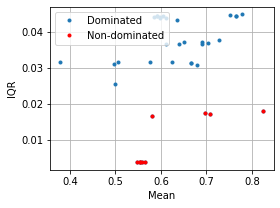

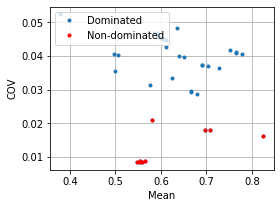

In [17]:
# Evaluate the solutions
ev_overall = Evaluator(inps, res)
ev_overall.add_function(ranker.mean, minimize=False)
ev_overall.add_function(ranker.iqr, minimize=True)
ev_overall.add_function(ranker.cov, minimize=True)

# ee.get_pareto_solutions()
par_sols = ev_overall.get_pareto_solutions()

# Plot the pareto solutions for the overall objective
plt.figure(figsize=[4,3])
plt.plot(ranker.mean(res), ranker.iqr(res), '.', label='Dominated')
plt.plot(ranker.mean(res)[par_sols], ranker.iqr(res)[par_sols], '.r', label='Non-dominated')
plt.xlabel('Mean')
plt.ylabel('IQR')
plt.grid()
plt.legend(loc=2)
plt.show()

plt.figure(figsize=[4,3])
plt.plot(ranker.mean(res), ranker.cov(res), '.', label='Dominated')
plt.plot(ranker.mean(res)[par_sols], ranker.cov(res)[par_sols], '.r', label='Non-dominated')
plt.xlabel('Mean')
plt.ylabel('COV')
plt.grid()
plt.legend(loc=2)
plt.show()
